## Importing Libraries

In [1]:
import sys
#!{sys.executable} -m pip install graphviz
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m brew install gcc@5

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mnso
import pandas_profiling
%matplotlib inline

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm  
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

### Loading the Data

In [4]:
Main_Data = pd.read_csv('data.csv')
Main_Data.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Foreign_schooled,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,No,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,Yes,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,Yes,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,Yes,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,Yes,No,No,1,0


In [53]:
Data_Prof_Main_Data = Main_Data.profile_report(title ='Pandas Profiling Report', plot={'histogram': {'bins': 8}})
rejected_variables = Data_Prof_Main_Data.get_rejected_variables(threshold=0.9)
Data_Prof_Main_Data

### Preparing a comprehensive exploratory data analysis (EDA)

* The Summary of a DataFrame helps to understand the type of variable, data type and presence of null values.

In [5]:
# The size of Data set
print('The size of the Train_Riders data is :', Main_Data.size)

# Show dimension of the data
print("Dimension: {}".format(Main_Data.shape))

The size of the Train_Riders data is : 651304
Dimension: (38312, 17)


* The size of Main_Data is 651304 which is made up of the number of rows times the number of columns of the DataFrame.
* The Main_Data comprises of 38312 observations and 17 features,
* out of which one is dependent variable (Target - Promoted_or_Not) and the remaining 18 are independent variables.

In [6]:
print(Main_Data.columns.values)

['EmployeeNo' 'Division' 'Qualification' 'Gender' 'Channel_of_Recruitment'
 'Trainings_Attended' 'Year_of_birth' 'Last_performance_score'
 'Year_of_recruitment' 'Targets_met' 'Previous_Award'
 'Training_score_average' 'Foreign_schooled' 'Past_Disciplinary_Action'
 'Previous_IntraDepartmental_Movement' 'No_of_previous_employers'
 'Promoted_or_Not']


- Lable of each column of the Dataset

In [7]:
print(Main_Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 17 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
Foreign_schooled                       38312 non-null object
Past_Disciplinary_Action               38312 non-null object
Previous_IntraDepartmental_Movement    383

* The Data have float64, object and integer values
* In the dataset, Qualification column have null/missing values

## Summary Statistics

In [8]:
Target_Column = ['Promoted_or_Not']
Predictors = list(set(list(Main_Data.columns))-set(Target_Column))
Numeric_Data = Main_Data._get_numeric_data()
Stat_of_Main_Data = Numeric_Data.describe(include='all')
Stat_of_Main_Data = Stat_of_Main_Data.transpose()
Stat_of_Main_Data.to_csv('Descriptive_Statistics_of_Data.csv', index=False)
Stat_of_Main_Data

,count,mean,std,min,25%,50%,75%,max
Trainings_Attended,38312.0,2.253680,0.609443,2.0,2.0,2.0,2.0,11.0
Year_of_birth,38312.0,1986.209334,7.646047,1950.0,1982.0,1988.0,1992.0,2001.0
Last_performance_score,38312.0,7.698959,3.744135,0.0,5.0,7.5,10.0,12.5
Year_of_recruitment,38312.0,2013.139695,4.261451,1982.0,2012.0,2014.0,2016.0,2018.0
Targets_met,38312.0,0.352996,0.477908,0.0,0.0,0.0,1.0,1.0
Previous_Award,38312.0,0.023152,0.150388,0.0,0.0,0.0,0.0,1.0
Training_score_average,38312.0,55.366465,13.362741,31.0,43.0,52.0,68.0,91.0
Promoted_or_Not,38312.0,0.084595,0.278282,0.0,0.0,0.0,0.0,1.0


## Key Observations -

* Mean value is greater than the median value of each column represented by 50%(50th percentile) in the row
* Notably, there is a large differnece in 75th percentile and Max values of predictors "Trainings_Attended", "Year_of_birth", "Year_of_recruitment" and "Training_score_average" but the remaining predictors have small (or equal) difference in the 75th percentile and Max values 
* Thus, observations 1 and 2 suggests that there are extreme values/Outliers in some part of our dataset. *We confirmed this by using boxplot as it is better visualisation for outliers* 

## To Check for Outliers

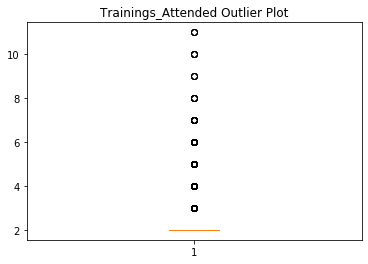

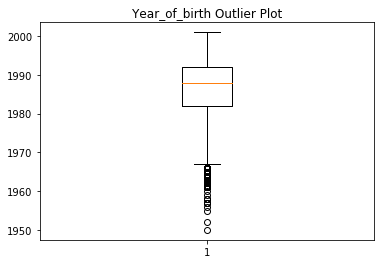

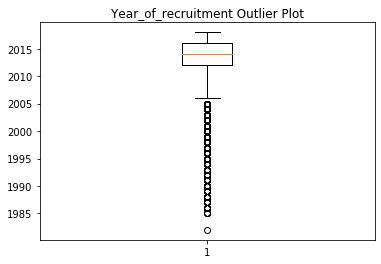

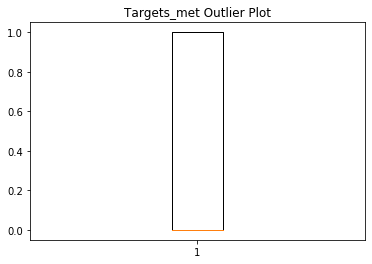

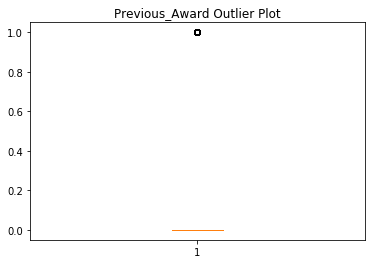

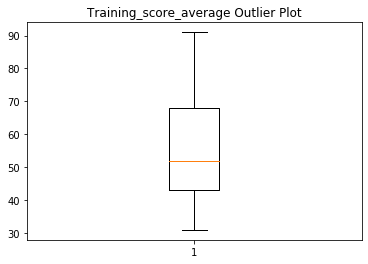

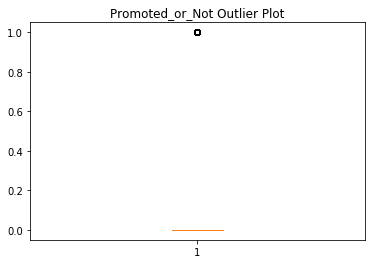

In [10]:
def Detecting_Outliers(Data):
    
    threshold=1
    mean = np.mean(Data) # computing mean of the dataset
    std =np.std(Data)  # computing the standard deviation
    
    for y in Data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            Outliers.append(y)        
    return Outliers

fig=plt.figure()

for i  in range(0,len(Main_Data.columns)):
    Outliers=[]
   
    if Main_Data[Main_Data.columns[i]].dtypes== np.int64 or Main_Data[Main_Data.columns[i]].dtypes== np.int64  :
        
        Outliers=Detecting_Outliers(Main_Data.iloc[:,i])
        if len(Outliers)>0:
                   
            ax = plt.subplot(1,1,1)
            #Variable
            ax.boxplot(Main_Data[list(Main_Data.columns)[i]])
            plt.title(list(Main_Data.columns)[i] + " Outlier Plot")
            plt.show()

* The Numerical (int64) features with the Black dots either above or below the whisk are all having outliers
* Outliers are performed on Numerical Variables of the Dataset

In [50]:
# Numeric Data
Numeric_Data = Main_Data._get_numeric_data()
Numeric_Data.head(3)

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not
0,2,1986,12.5,2011,1,0,41,0
1,2,1991,12.5,2015,0,0,52,0
2,2,1987,7.5,2012,0,0,42,0


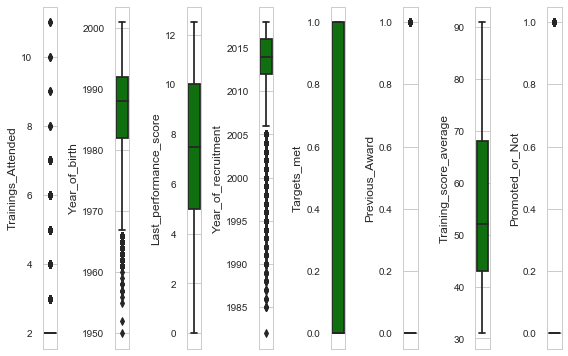

In [55]:
lent = Numeric_Data.columns.values
number_of_columns = 8
number_of_rows = len(lent)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(lent)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(Numeric_Data[lent[i]],color='green',orient='v')
    plt.tight_layout()

## Performing KDE

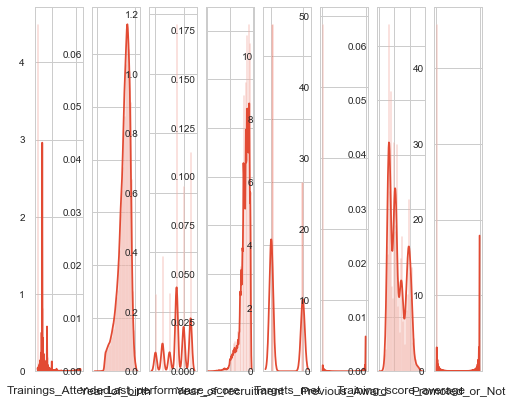

In [59]:
plt.figure(figsize=(number_of_columns, 8*number_of_rows))
for i in range(0,len(lent)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    chart=sns.distplot(Numeric_Data[lent[i]], kde=True) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=None, 
                          horizontalalignment='right')
plt.show()

## Univariate Analysis

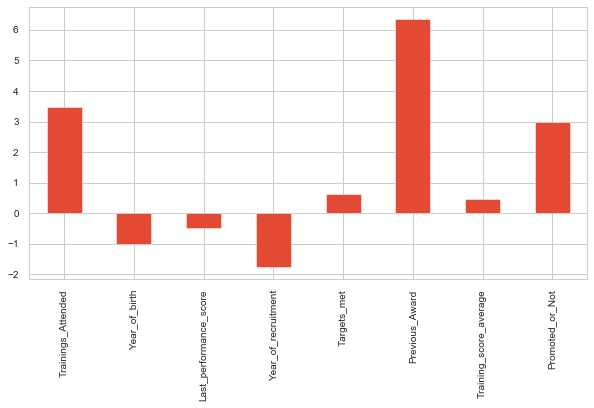

In [63]:
# Calculating Skewness in the columns of our Numeric dataset

Numeric_Data.skew().plot.bar(figsize =(10,5))
plt.show()

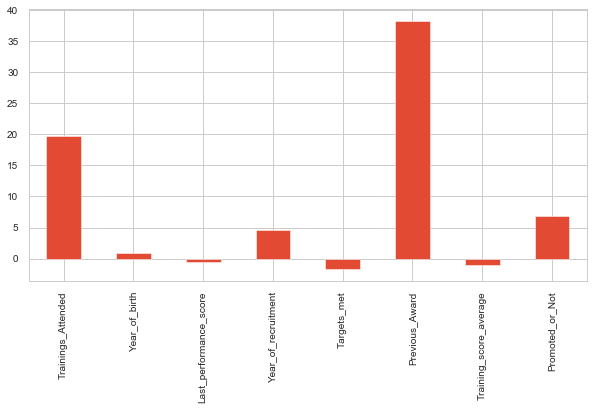

In [62]:
# Measuring Kurtosis in our Numeric dataset

Numeric_Data.kurt().plot.bar(figsize =(10,5))
plt.show()

## Understanding the Target Variable

In [13]:
Main_Data['Promoted_or_Not'].unique()

array([0, 1])

* Target variable/Dependent variable is dummy variable in nature. 
* If the Employee is Promoted, it is a 1 and if Not, it is a 0.

In [14]:
Main_Data['Promoted_or_Not'].value_counts(sort=True)

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

* This tells us the vote count of whether employees are promoted or not in descending order.
* Promoted_or_Not has most values concentrated on _Not Promoted_
* Few employees are mostly Promoted. $\textbf{Therefore, we can infer that the data is imbalanced}$

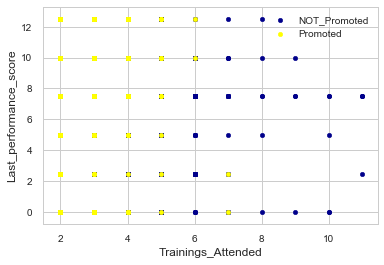

In [74]:
ax = Main_Data[Main_Data['Promoted_or_Not'] == 0].plot(kind='scatter', x='Trainings_Attended', 
                                                                         y='Last_performance_score',
                                                                         color='DarkBlue', 
                                                       label='NOT_Promoted');
Main_Data[Main_Data['Promoted_or_Not'] == 1].plot(kind='scatter', x='Trainings_Attended',
                                                                    y='Last_performance_score', 
                                    color='Yellow', label='Promoted', ax=ax);
plt.show()

## Visualising the Dataset
### Checking for Missing Values in the Data

## Missing Values

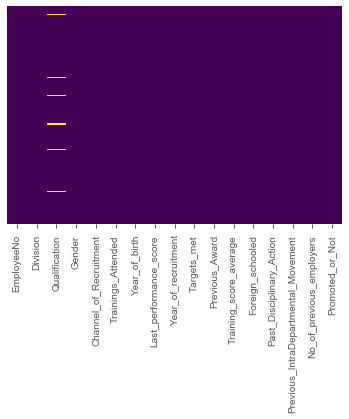

In [15]:
import matplotlib.style as style
style.use('ggplot')
sns.heatmap(Main_Data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

* The Dataset has missing values in the _"Qualification"_ Variable
* The missing values are noticed in figure (above) represented by yellow colour shade on the purple background.

In [16]:
# Total number of missing values in the data 
Missing_values = Main_Data.isnull().sum()
print('The missing values is show below :', Missing_values)

The missing values is show below : EmployeeNo                                0
Division                                  0
Qualification                          1679
Gender                                    0
Channel_of_Recruitment                    0
Trainings_Attended                        0
Year_of_birth                             0
Last_performance_score                    0
Year_of_recruitment                       0
Targets_met                               0
Previous_Award                            0
Training_score_average                    0
Foreign_schooled                          0
Past_Disciplinary_Action                  0
Previous_IntraDepartmental_Movement       0
No_of_previous_employers                  0
Promoted_or_Not                           0
dtype: int64


In [18]:
# The Percentage of missing values in the dataset
Percent_Missing = Main_Data.isna().mean().round(4) * 100
print('The percentage of missing values in the dataset is:', Percent_Missing)

The percentage of missing values in the dataset is: EmployeeNo                             0.00
Division                               0.00
Qualification                          4.38
Gender                                 0.00
Channel_of_Recruitment                 0.00
Trainings_Attended                     0.00
Year_of_birth                          0.00
Last_performance_score                 0.00
Year_of_recruitment                    0.00
Targets_met                            0.00
Previous_Award                         0.00
Training_score_average                 0.00
Foreign_schooled                       0.00
Past_Disciplinary_Action               0.00
Previous_IntraDepartmental_Movement    0.00
No_of_previous_employers               0.00
Promoted_or_Not                        0.00
dtype: float64


* The Data has total percent missing cells of  0.3% (from the Pandas_Profiling above)
* The percentage of missing values in the Qualification variable is 4.38%

## Checking for Correlation

### Correlation Matrix

In [19]:
Corr_Matrix = Main_Data.corr()
Corr_Matrix

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not
Trainings_Attended,1.000000,0.078710,-0.062042,0.056215,-0.044789,-0.007409,0.041065,-0.024345
Year_of_birth,0.078710,1.000000,-0.175572,0.654666,0.025337,0.013627,0.048390,0.017991
Last_performance_score,-0.062042,-0.175572,1.000000,-0.190333,0.276350,0.026587,0.057836,0.119690
Year_of_recruitment,0.056215,0.654666,-0.190333,1.000000,0.076910,0.041995,0.037477,0.012287
Targets_met,-0.044789,0.025337,0.276350,0.076910,1.000000,0.092934,0.077201,0.224518
Previous_Award,-0.007409,0.013627,0.026587,0.041995,0.092934,1.000000,0.072360,0.201434
Training_score_average,0.041065,0.048390,0.057836,0.037477,0.077201,0.072360,1.000000,0.178448
Promoted_or_Not,-0.024345,0.017991,0.119690,0.012287,0.224518,0.201434,0.178448,1.000000


* From the Correlation Matrix above, we see that the _"Trainings_Attended"_ variable has high correlation with the other variables but not a basis to conclude that it is an important feature or not.
* The _"Previous_Award"_ variable has very low correlation with the remaining variables and can infer that it is neglible. However, the correlation matrix is not a basis to drop or remove feature as it can be deceicing. 

#### A seaborn heatmap to better show the correlation matrix

In [27]:
plt.subplot?

Text(0.5, 1, 'Heatmap')

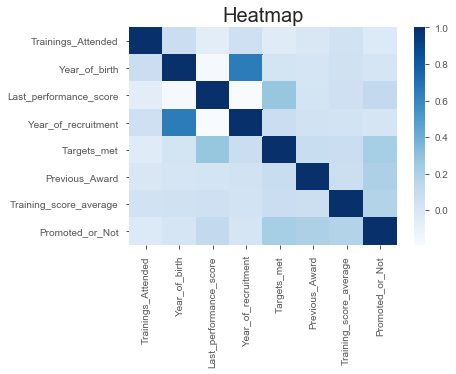

In [37]:
import matplotlib.style as style
style.use('ggplot')

plt.subplots() #(figsize=(6,4))
sns.heatmap(Corr_Matrix,cmap='Blues',annot=False) 
plt.title('Heatmap', fontsize=20)

* Dark shades in the Dataset represents positive correlation while lighter shades represents negative correlation and the faded represents No or weak correlation.
* If we set annot=True, you'll get values by which features are correlated to each other in grid-cells. The code is implemented below

Text(0.5, 1, 'Pearson Correlation of Features')

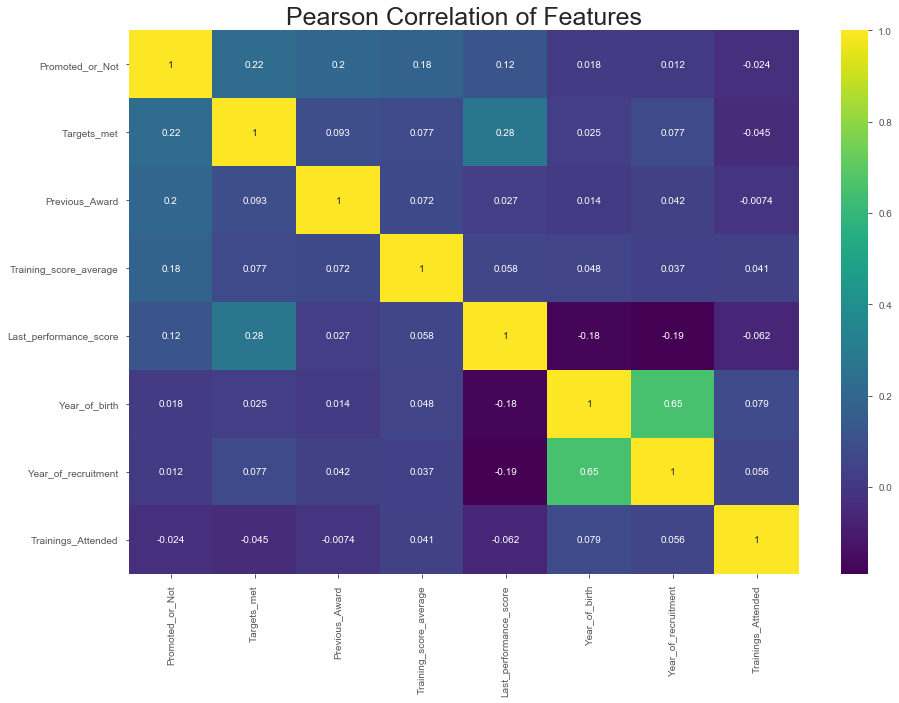

In [40]:
import matplotlib.style as style
style.use('ggplot')

k = 17  # number of variables of Data for heatmap
cols = Corr_Matrix.nlargest(k, 'Promoted_or_Not')['Promoted_or_Not'].index
cm = Main_Data[cols].corr()
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Pearson Correlation of Features', fontsize=25)

### Creating a copy of the Main Data

In [64]:
New_Data = Main_Data.copy()

## Dealing with Missing Values

In [65]:
New_Data['Qualification'].fillna('First Degree or HND', inplace=True)
New_Data.Qualification.head(10)

0       MSc, MBA and PhD
1    First Degree or HND
2    First Degree or HND
3    First Degree or HND
4    First Degree or HND
5    First Degree or HND
6       MSc, MBA and PhD
7    First Degree or HND
8       MSc, MBA and PhD
9    First Degree or HND
Name: Qualification, dtype: object

* We filled all NaN's with the mode of the Qualification Variable, with which we can infer that the company employs people with First Degree or HND

In [66]:
Missing = New_Data.isnull().sum()
Missing

EmployeeNo                             0
Division                               0
Qualification                          0
Gender                                 0
Channel_of_Recruitment                 0
Trainings_Attended                     0
Year_of_birth                          0
Last_performance_score                 0
Year_of_recruitment                    0
Targets_met                            0
Previous_Award                         0
Training_score_average                 0
Foreign_schooled                       0
Past_Disciplinary_Action               0
Previous_IntraDepartmental_Movement    0
No_of_previous_employers               0
Promoted_or_Not                        0
dtype: int64

In [67]:
# Saving the cleaned datasets
New_Data.to_csv('Data_cleaned.csv')

# Feature Engineering

### Encoding Categorical Variables

In [68]:
Numeric_Data = Main_Data._get_numeric_data()
Numeric_Data.head()

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not
0,2,1986,12.5,2011,1,0,41,0
1,2,1991,12.5,2015,0,0,52,0
2,2,1987,7.5,2012,0,0,42,0
3,3,1982,2.5,2009,0,0,42,0
4,3,1990,7.5,2012,0,0,77,0


In [69]:
Categorical_Feature = Main_Data.drop(['EmployeeNo'], axis=1, inplace=True)
Categorical_Feature = Main_Data.select_dtypes(include=['object'])
Categorical_Feature.head(2)

,Division,Qualification,Gender,Channel_of_Recruitment,Foreign_schooled,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,No,No,No,0
1,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,Yes,No,No,0


In [70]:
Categorical_Variables = pd.get_dummies(Categorical_Feature)
Categorical_Variables.head(2)

,Division_Business Finance Operations,Division_Commercial Sales and Marketing,Division_Customer Support and Field Operations,Division_Information Technology and Solution Support,Division_Information and Strategy,Division_People/HR Management,Division_Regulatory and Legal services,Division_Research and Innovation,Division_Sourcing and Purchasing,Qualification_First Degree or HND,...,Past_Disciplinary_Action_Yes,Previous_IntraDepartmental_Movement_No,Previous_IntraDepartmental_Movement_Yes,No_of_previous_employers_0,No_of_previous_employers_1,No_of_previous_employers_2,No_of_previous_employers_3,No_of_previous_employers_4,No_of_previous_employers_5,No_of_previous_employers_More than 5
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0


In [71]:
Complete_Variables = pd.concat([Numeric_Data, Categorical_Variables], axis=1)
Complete_Variables.head(2)

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not,Division_Business Finance Operations,Division_Commercial Sales and Marketing,...,Past_Disciplinary_Action_Yes,Previous_IntraDepartmental_Movement_No,Previous_IntraDepartmental_Movement_Yes,No_of_previous_employers_0,No_of_previous_employers_1,No_of_previous_employers_2,No_of_previous_employers_3,No_of_previous_employers_4,No_of_previous_employers_5,No_of_previous_employers_More than 5
0,2,1986,12.5,2011,1,0,41,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,2,1991,12.5,2015,0,0,52,0,0,0,...,0,1,0,1,0,0,0,0,0,0


## Check for class imbalance in the dataset.

In [75]:
Complete_Variables['Promoted_or_Not'].value_counts(sort=True)

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

- We can see that the Majority Class is the Not Promoted which is represented by zero (0).
- The Minority Class is the Promoted which is represented by one (1). 

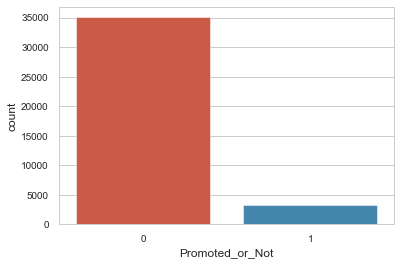

In [76]:
# Now lets check the Promoted_or_Not distributions
sns.countplot("Promoted_or_Not", data=Complete_Variables)

- As we know data is imbalanced and the graph shown above also confirmed it

### Checking for the Percentages of the Imbalance

In [77]:
# now let us check in the number of Percentages 

# Promoted are repersented by 1
Count_Promoted = len(Complete_Variables[Complete_Variables["Promoted_or_Not"] == 1])
# Not Promoted by 0
Count_Not_Promoted = len(Complete_Variables[Complete_Variables["Promoted_or_Not"] == 0])

Percentage_of_Promoted = Count_Promoted/(Count_Promoted + Count_Not_Promoted)
print("Percentage of Promoted is: ", Percentage_of_Promoted * 100)

Percentage_of_Not_Promoted = Count_Not_Promoted/(Count_Promoted + Count_Not_Promoted)
print("Percentage of Not Promoted is: ", Percentage_of_Not_Promoted * 100)

Percentage of Promoted is:  8.459490499060347
Percentage of Not Promoted is:  91.54050950093965


* Hence, in data there is only 8.46% that are promoted while 91.54 are not promoted
* So now we have to solve the imbalance class problem by resampling the data, using up-sample Minority Class and SMOTE

## Splitting the Dataset

In [78]:
# Separate input features (X) and target variable (Y)
Y = Complete_Variables['Promoted_or_Not']
X = Complete_Variables.drop('Promoted_or_Not', axis=1)

In [81]:
print(X.shape);
Y.shape

(38312, 37)


(38312,)

In [82]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [84]:
print(X_Train.shape);
Y_Train.shape

(30649, 37)


(30649,)

In [86]:
X_Train.head(4)

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Division_Business Finance Operations,Division_Commercial Sales and Marketing,Division_Customer Support and Field Operations,...,Past_Disciplinary_Action_Yes,Previous_IntraDepartmental_Movement_No,Previous_IntraDepartmental_Movement_Yes,No_of_previous_employers_0,No_of_previous_employers_1,No_of_previous_employers_2,No_of_previous_employers_3,No_of_previous_employers_4,No_of_previous_employers_5,No_of_previous_employers_More than 5
35858,2,1995,12.5,2016,1,0,39,0,1,0,...,0,1,0,1,0,0,0,0,0,0
15175,2,1986,5.0,2010,0,0,52,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1277,2,1987,5.0,2011,0,0,56,0,0,1,...,0,1,0,1,0,0,0,0,0,0
27209,2,1993,12.5,2016,0,0,38,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [90]:
Y_Train.head(2)

35858    0
15175    0
Name: Promoted_or_Not, dtype: int64

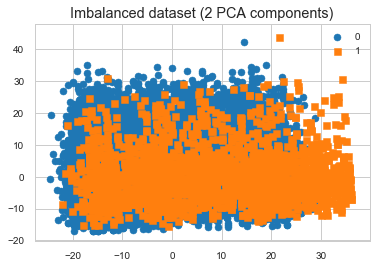

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X_Train)

plot_2d_space(X, Y_Train, 'Imbalanced dataset (2 PCA components)')

## Resampling Using "Up-Sampled Minority Class"

#### We'll create a new DataFrame with an up-sampled minority class

In [104]:
def plot_2d_space(X, Y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(Y), colors, markers):
        plt.scatter(
            X[Y==l, 0],
            X[Y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='down')
    plt.show()

Removed indexes: [ 1621 16271 24842 ... 30605 30608 30638]


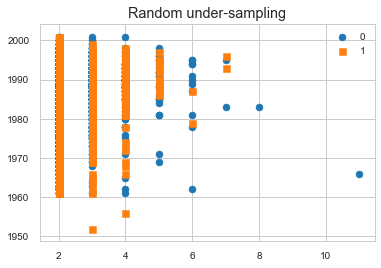

In [105]:
RUS = RandomUnderSampler(return_indices=True)
X_RUS, Y_RUS, id_rus = RUS.fit_sample(X_Train, Y_Train)

print('Removed indexes:', id_rus)

plot_2d_space(X_RUS, Y_RUS, 'Random under-sampling')

In [103]:
# Separate majority and minority classes
#Complete_Variables_majority = Complete_Variables[Complete_Variables['Promoted_or_Not']==0]
#Complete_Variables_minority = Complete_Variables[Complete_Variables['Promoted_or_Not']==1]
 
# Upsample minority class
#Complete_Variables_minority_upsampled = resample(Complete_Variables_minority, 
    #                             replace=True,     # sample with replacement
   #                              n_samples=35071,    # to match majority class
  #                               random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
#Complete_Variables_upsampled = pd.concat([Complete_Variables_majority, 
 #                                       Complete_Variables_minority_upsampled])
 
# Display new class counts
#Complete_Variables_upsampled['Promoted_or_Not'].value_counts()

* First, we separated the observations from each class into different DataFrames.
* Next, we resampled the minority class with replacement, setting the number of samples to match that of the majority class.
* And finally, we combined the up-sampled minority class DataFrame with the original majority class DataFrame.
* Hence, as we can see, the new DataFrame has more observations than the original, and the ratio of the two classes is now 1:1.

#### Using Logistic Regression

In [277]:
# Train model
lr = LogisticRegression(random_state=42).fit(X_Train, Y_Train)
 
# Predict on training set
pred_y = lr.predict(X_Test)
 
# Is our model still predicting just one class?
print(np.unique(pred_y))
 
# How's our accuracy?
print(confusion_matrix(Y_Test, pred_y))
print("Accuracy: %.2f%%" % accuracy_score(Y_Test, pred_y))
print(classification_report(Y_Test, pred_y))

/home/iamgoddey/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 1]
[[5281 1715]
 [1281 5752]]
Accuracy: 0.79%
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      6996
           1       0.77      0.82      0.79      7033

    accuracy                           0.79     14029
   macro avg       0.79      0.79      0.79     14029
weighted avg       0.79      0.79      0.79     14029



In [278]:
# Building a basic random forest using the RandomForestClassifier method
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_Train, Y_Train)
rfc_prediction = random_forest.predict(X_Test)

print(np.unique(rfc_prediction))
print("Accuracy: %.2f%%" % accuracy_score(Y_Test, rfc_prediction))
print(classification_report(Y_Test, rfc_prediction))

/home/iamgoddey/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0 1]
Accuracy: 0.98%
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6996
           1       0.97      1.00      0.98      7033

    accuracy                           0.98     14029
   macro avg       0.98      0.98      0.98     14029
weighted avg       0.98      0.98      0.98     14029



In [279]:
# Building a basic SVM model using the SVC method
support_vector = SVC(random_state=42)
support_vector.fit(X_Train, Y_Train)
s_prediction = support_vector.predict(X_Test)

print(np.unique(s_prediction))
print("Accuracy: %.2f%%" % accuracy_score(Y_Test, s_prediction))
print(classification_report(Y_Test , s_prediction))

/home/iamgoddey/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0 1]
Accuracy: 0.86%
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      6996
           1       0.80      0.97      0.87      7033

    accuracy                           0.86     14029
   macro avg       0.88      0.86      0.86     14029
weighted avg       0.88      0.86      0.86     14029



In [280]:
# Implementing a basic decision tree using DecisionTreeClassifier method
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree = decision_tree.fit(X_Train,Y_Train)
dtc_prediction = decision_tree.predict(X_Test)

print(np.unique(dtc_prediction))
print("Accuracy: %.2f%%" % accuracy_score(Y_Test, dtc_prediction))
print(classification_report(Y_Test , dtc_prediction))

[0 1]
Accuracy: 0.97%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6996
           1       0.94      1.00      0.97      7033

    accuracy                           0.97     14029
   macro avg       0.97      0.97      0.97     14029
weighted avg       0.97      0.97      0.97     14029



In [247]:
# fit XgBoost model on training data
model = XGBClassifier()
model.fit(X_Train, Y_Train)

# make predictions for test data
y_pred = model.predict(X_Test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(np.unique(dtc_prediction))
accuracy = accuracy_score(Y_Test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
classification = classification_report(Y_Test, predictions)
print(classification)

[0 1]
Accuracy: 82.24%
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      6996
           1       0.75      0.96      0.84      7033

    accuracy                           0.82     14029
   macro avg       0.85      0.82      0.82     14029
weighted avg       0.85      0.82      0.82     14029



In [248]:
#import sys
#!{sys.executable} -m pip install graphviz

In [249]:
import graphviz

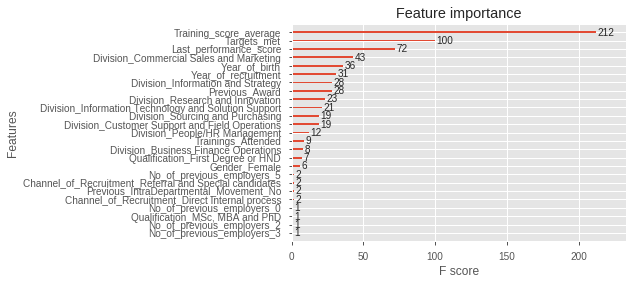

In [266]:
xgb_model = XGBClassifier(objective="binary:logistic", 
                              random_state=42, eval_metric="auc")

xgb_model.fit(X_Train, Y_Train, early_stopping_rounds=10, eval_set=[(X_Train, Y_Train),(X_Test, Y_Test)], 
              verbose=False)

xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
#xgb.plot_tree(xgb_model, num_trees = xgb_model.best_iteration)

# converts the target tree to a graphviz instance
#xgb.to_graphviz(xgb_model, num_trees = xgb_model.best_iteration)

In [150]:
??xgb_model.fit

In [267]:
evals_result = xgb_model.evals_result()
evals_result

{'validation_0': {'auc': [0.800318,
   0.801857,
   0.806501,
   0.820838,
   0.820289,
   0.824646,
   0.828257,
   0.827945,
   0.828827,
   0.830459,
   0.829684,
   0.829711,
   0.830049,
   0.824004,
   0.830045,
   0.830441,
   0.827754,
   0.832019,
   0.839636,
   0.842129,
   0.843318,
   0.848436,
   0.848783,
   0.852861,
   0.855462,
   0.859319,
   0.859248,
   0.858535,
   0.861109,
   0.864322,
   0.864556,
   0.864399,
   0.865972,
   0.865948,
   0.866745,
   0.869064,
   0.870189,
   0.871883,
   0.873824,
   0.874342,
   0.877407,
   0.879056,
   0.879585,
   0.880853,
   0.881508,
   0.882416,
   0.882641,
   0.882181,
   0.882793,
   0.882972,
   0.883306,
   0.883515,
   0.884269,
   0.885719,
   0.885908,
   0.885537,
   0.886476,
   0.888616,
   0.889388,
   0.889569,
   0.889859,
   0.889973,
   0.891155,
   0.892648,
   0.89272,
   0.893983,
   0.895,
   0.895475,
   0.895374,
   0.896781,
   0.896795,
   0.897141,
   0.897637,
   0.897992,
   0.898417,
   0.8

In [97]:
#import sys
#!{sys.executable} -m pip install imblearn
#!{sys.executable} -m pip install Xgboost
#!{sys.executable} -m pip install -U imbalanced-learn

In [94]:
Y_Data = Complete_Variables['Promoted_or_Not']
X_Data = Complete_Variables.drop('Promoted_or_Not',axis=1)

In [64]:
X_Data.shape, Y_Data.shape

((38312, 37), (38312,))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=0.2,
                                               random_state=42)

In [275]:
X_resample, y_resampled = SMOTE().fit_resample(X_train, y_train)
x_resampled, Y_resample = SMOTE().fit_resample(X_test, y_test)
print(sorted(Counter(y_resampled).items()))
print(sorted(Counter(Y_resample).items()))

clf = LogisticRegression()
clf = clf.fit(X_resample, y_resampled)
#print(clf_smote)

[(0, 28075), (1, 28075)]
[(0, 6996), (1, 6996)]


/home/iamgoddey/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [276]:
pred_y_1 = clf.predict(x_resampled)

print(np.unique(pred_y_1))
print("Accuracy: %.2f%%" % accuracy_score(Y_resample, pred_y_1))
print(classification_report(Y_resample, pred_y_1))

[0 1]
Accuracy: 0.80%
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      6996
           1       0.77      0.83      0.80      6996

    accuracy                           0.80     13992
   macro avg       0.80      0.80      0.80     13992
weighted avg       0.80      0.80      0.80     13992



In [274]:
# Building a basic SVM model using the SVC method
support_vector = SVC(random_state=42)
support_vector.fit(X_resample, y_resampled)
s_prediction = support_vector.predict(x_resampled)

print(np.unique(s_prediction))
print("Accuracy: %.2f%%" % accuracy_score(Y_resample, s_prediction))
print(classification_report(Y_resample , s_prediction))

/home/iamgoddey/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0 1]
Accuracy: 0.80%
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6996
           1       0.80      0.81      0.81      6996

    accuracy                           0.80     13992
   macro avg       0.80      0.80      0.80     13992
weighted avg       0.80      0.80      0.80     13992



In [273]:
# Building a basic random forest using the RandomForestClassifier method
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_resample, y_resampled)
rfc_prediction = random_forest.predict(x_resampled)

print(np.unique(rfc_prediction))
print("Accuracy: %.2f%%" % accuracy_score(rfc_prediction, Y_resample))
print(classification_report(rfc_prediction, Y_resample))

/home/iamgoddey/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0 1]
Accuracy: 0.94%
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      7652
           1       0.89      0.98      0.94      6340

    accuracy                           0.94     13992
   macro avg       0.94      0.94      0.94     13992
weighted avg       0.94      0.94      0.94     13992



In [271]:
# Implementing a basic decision tree using DecisionTreeClassifier method
decision_Tree = DecisionTreeClassifier(random_state=42)
decision_Tree = decision_tree.fit(X_resample, y_resampled)
dtc_prediction = decision_tree.predict(x_resampled)

print(np.unique(dtc_prediction))
print("Accuracy: %.2f%%" % accuracy_score(Y_resample, dtc_prediction))
print(classification_report(Y_resample, dtc_prediction))

[0 1]
Accuracy: 0.92%
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6996
           1       0.93      0.90      0.92      6996

    accuracy                           0.92     13992
   macro avg       0.92      0.92      0.92     13992
weighted avg       0.92      0.92      0.92     13992



In [204]:
# fit XgBoost model on training data
model = XGBClassifier()
model.fit(X_resample, y_resampled)

# make predictions for test data
y_predict = model.predict(x_resampled)

# evaluate predictions
print(np.unique(y_predict))
accuracy = accuracy_score(Y_resample, y_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
classification = classification_report(Y_resample, y_predict)
print(classification)

[0 1]
Accuracy: 94.85%
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6996
           1       0.99      0.90      0.95      6996

    accuracy                           0.95     13992
   macro avg       0.95      0.95      0.95     13992
weighted avg       0.95      0.95      0.95     13992



In [213]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [251]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42, 
                             eval_metric=["auc", "error", 'logloss',"error@0.6"])

scores = cross_val_score(xgb_model, X_resample, y_resampled, 
                         scoring="neg_mean_squared_error", cv=5)

display_scores(np.sqrt(-scores))

Scores: [0.45929599 0.14342211 0.13075573 0.14154723 0.13477992]
Mean: 0.202
Std: 0.129


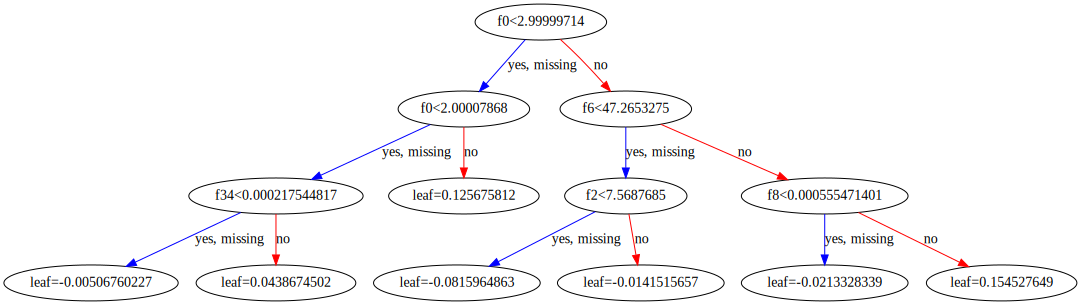

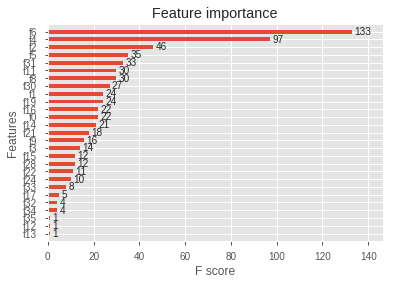

In [256]:
X_resample, y_resampled = SMOTE().fit_resample(X_train, y_train)
xgb_model = XGBClassifier(objective="binary:logistic", reg_alpha=0.01,
                              random_state=42, eval_metric=["auc", "error",'logloss',"error@0.6"])

xgb_model.fit(X_resample, y_resampled, early_stopping_rounds=10, 
              eval_set=[(X_resample, y_resampled),(x_resampled, Y_resample)], verbose=False)

xgb.plot_importance(xgb_model, height=0.5)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
#xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

In [257]:
print("best score: {0},\n best iteration: {1},\n best ntree limit {2}".format(xgb_model.best_score, 
      xgb_model.best_iteration, xgb_model.best_ntree_limit))

best score: 0.058962,
 best iteration: 98,
 best ntree limit 99


In [265]:
evals_result = xgb_model.evals_result()
evals_result

{'validation_0': {'auc': [0.869371,
   0.877151,
   0.887911,
   0.894155,
   0.893505,
   0.894905,
   0.902816,
   0.911609,
   0.910774,
   0.915005,
   0.914926,
   0.921361,
   0.920375,
   0.921425,
   0.92462,
   0.92821,
   0.937703,
   0.941942,
   0.94723,
   0.949358,
   0.951748,
   0.951473,
   0.955224,
   0.960009,
   0.961795,
   0.963003,
   0.963883,
   0.965626,
   0.967145,
   0.968061,
   0.968583,
   0.969928,
   0.971735,
   0.972716,
   0.973491,
   0.973368,
   0.973617,
   0.974464,
   0.974715,
   0.975204,
   0.975895,
   0.976802,
   0.977161,
   0.976973,
   0.977375,
   0.977652,
   0.977897,
   0.978476,
   0.978742,
   0.978822,
   0.979013,
   0.979151,
   0.980199,
   0.980399,
   0.9806,
   0.980626,
   0.980862,
   0.981074,
   0.981142,
   0.981187,
   0.981283,
   0.981652,
   0.981899,
   0.981964,
   0.982288,
   0.98269,
   0.98282,
   0.982885,
   0.983481,
   0.983678,
   0.983857,
   0.984103,
   0.984182,
   0.984285,
   0.984348,
   0.9843

## Summary